In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget svgling

In [21]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [22]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from wordcloud import WordCloud

import nltk
from mecab import MeCab

In [23]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


## 1. 데이터 분석

In [24]:
def text_analysis(df, label=None, test=False):
    if not test:
      print("*"*120)
      if label is None:
          text_question = df['text'].reset_index(drop=True)
          display(df.label.value_counts())
          norm_label = df.label.value_counts(normalize=True)
          display(norm_label)
          norm_label.plot.bar(figsize=(5,5),color=sns.color_palette('hls',n_colors = len(norm_label)))
          plt.show()
          df.info()
      else:
          text_question = df.loc[train_df['label'] == label, 'text'].reset_index(drop=True)
          display(f"유형: {label}",text_question.head(10))

    text_question = df['text'].reset_index(drop=True)
    # 데이터 확인
    display(text_question.describe(include='all'))
    # 데이터 길이 분포 시각화

    text_length = text_question.apply(len)
    display(pd.DataFrame(text_length).describe().T)
    print("-"*120)
    print("최대 길이: ", text_length.argmax())
    print("최소 길이: ", text_length.argmin())

    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1, title="max string length : "  + str(max(text_length)) )
    sns.histplot(text_length, bins=50)
    plt.grid()

    plt.subplot(2,1,2)
    sns.boxplot(x=text_length)
    plt.grid()
    plt.show()
    print("-"*120)

    mecab = MeCab()
    nouns = text_question.apply(lambda t:mecab.nouns(str(t)))
    nouns = nltk.Text(nouns.explode())
    nouns = nltk.Text([w for w in nouns if isinstance(w,str)])
    #word cloud
    cloud = WordCloud(
        max_font_size=100, max_words=50,
        background_color='white', relative_scaling=.5,
        width=800, height=600, font_path=FONT_PATH).generate(" ".join(nouns))
    plt.figure(figsize=(10, 8))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    display(nouns.vocab().most_common(n=10))

In [25]:
train_df= pd.read_csv(r'/content/drive/MyDrive/미프4_2/train.csv')
test_df= pd.read_csv(r'/content/drive/MyDrive/미프4_2/test.csv')

************************************************************************************************************************


코드2       1097
웹          732
이론         728
시스템 운영     561
코드1        488
원격         100
Name: label, dtype: int64

코드2       0.296006
웹         0.197518
이론        0.196438
시스템 운영    0.151376
코드1       0.131678
원격        0.026983
Name: label, dtype: float64

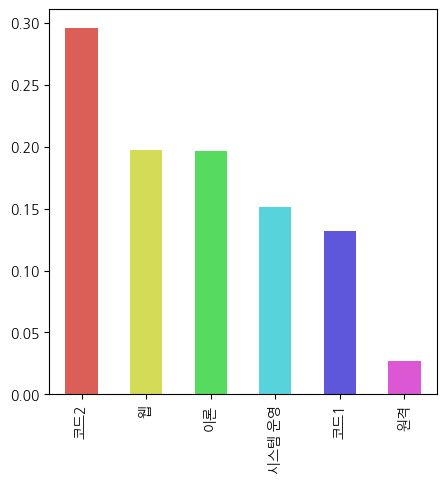

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


count                                                  3706
unique                                                 3706
top       self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...
freq                                                      1
Name: text, dtype: object

,count,mean,std,min,25%,50%,75%,max
text,3706.0,200.957366,330.558868,9.0,68.0,118.0,222.0,6012.0


------------------------------------------------------------------------------------------------------------------------
최대 길이:  2561
최소 길이:  756


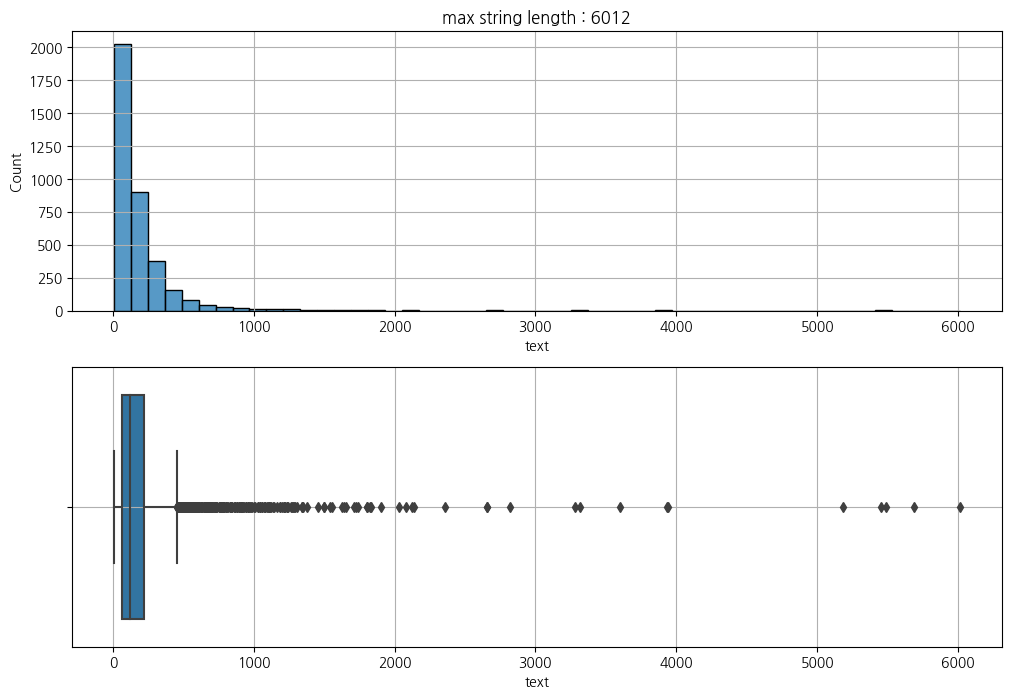

------------------------------------------------------------------------------------------------------------------------


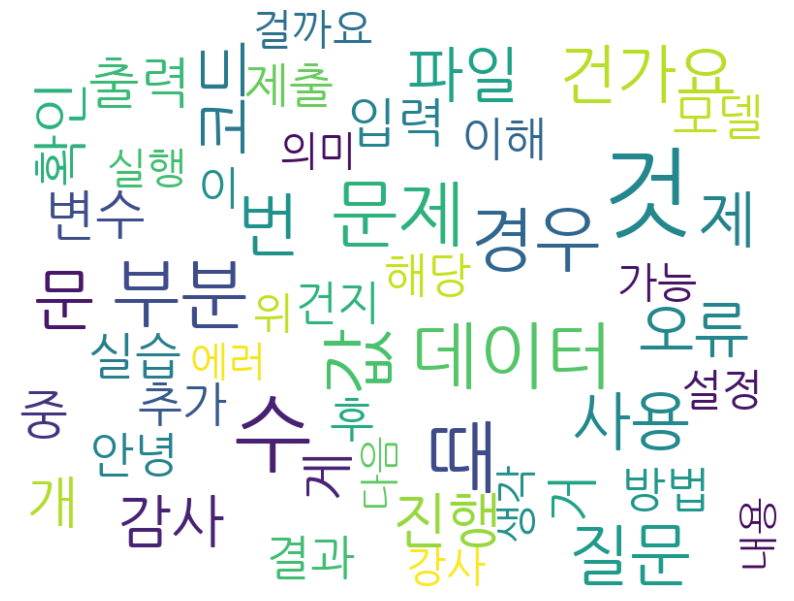

[('것', 1093),
 ('수', 986),
 ('값', 801),
 ('데이터', 783),
 ('문제', 725),
 ('때', 714),
 ('코드', 712),
 ('실습', 609),
 ('번', 596),
 ('파일', 581)]

In [26]:
text_analysis(train_df)

count                                                   929
unique                                                  929
top       팀즈는 노트북으로 접속하고 강의는 데스크톱 이용하려고 하는데 문제는 없을까요?  이...
freq                                                      1
Name: text, dtype: object

,count,mean,std,min,25%,50%,75%,max
text,929.0,184.844995,262.955462,9.0,64.0,115.0,207.0,2872.0


------------------------------------------------------------------------------------------------------------------------
최대 길이:  884
최소 길이:  312


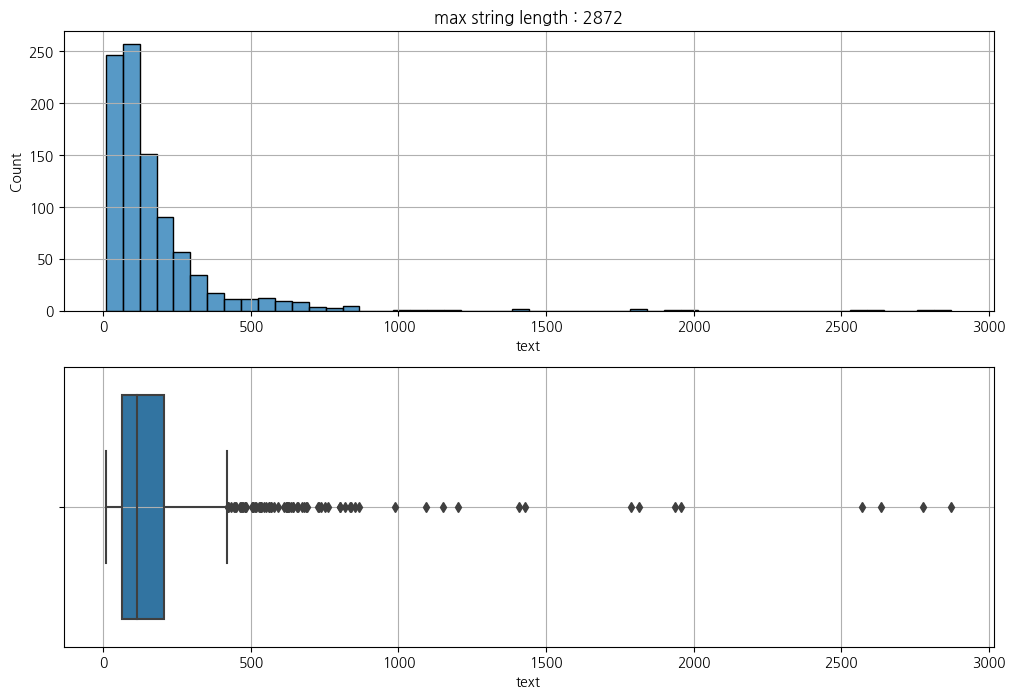

------------------------------------------------------------------------------------------------------------------------


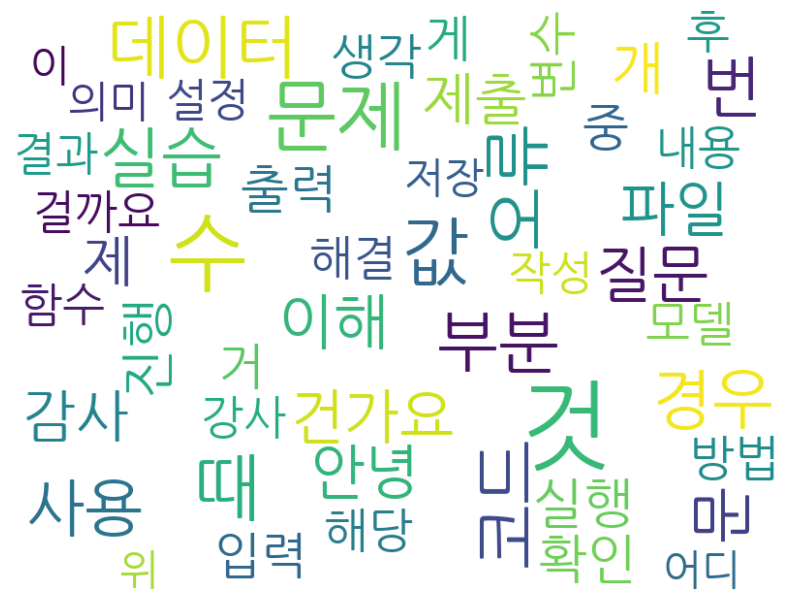

[('것', 295),
 ('수', 218),
 ('값', 188),
 ('데이터', 179),
 ('문제', 178),
 ('때', 151),
 ('코드', 151),
 ('오류', 149),
 ('감사', 128),
 ('실습', 122)]

In [27]:
text_analysis(test_df, test=True)

## 2. 데이터 전처리

In [29]:
# Your data and labels
data = train_df['text']
labels = train_df['label']

# Define label mapping
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

numeric_labels = [label_dict[label] for label in labels]
train_df = pd.DataFrame({'text': data, 'label': numeric_labels})

In [30]:
# 특수기호 제거.
import re

def remove_others(df):
  for index, row in df.iterrows():
      text = row['text']

      cleaned_text = re.sub(r'[^A-Za-z0-9가-힣\s]', '', text)
      df.at[index, 'text'] = cleaned_text

  return df

In [31]:
trian_df = remove_others(train_df)
test_df = remove_others(test_df)

In [32]:
x = train_df['text']
y = train_df['label']

In [17]:
# 데이터분할

x_train = train_df['text']
y_train = train_df['label']

x_test = test_df['text']

## 3. 토큰화

In [33]:
mecab = MeCab()

# N-grams
def mecab_tokenizer(string):
    # (형태소, 품사) 쌍을 /로 구분한 문자열로 반환
    # mecab.pos -> 품사 단위 분석
    return list('/'.join(res) for res in mecab.pos(str(string)))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

mecab_cv = CountVectorizer(tokenizer=mecab_tokenizer)
x_mecab_cv = mecab_cv.fit_transform(x)

tf_transformer = TfidfTransformer()
x_me_tf = tf_transformer.fit_transform(x_mecab_cv)

# Split
x_train, x_test, y_train, y_test = train_test_split(x_me_tf, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [34]:
# adasyn = ADASYN(random_state=42)
# smote =SMOTE(random_state=42)

# x_train, y_train = adasyn.fit_resample(x_train, y_train)
# x_train_rsm, y_train_rsm = smote.fit_resample(x_train_seq, y_train)

# Hyperparameter
param_grid = {
    'C': [0.1, 1, 10],
    # 'kernel': ['linear', 'rbf','sigmoid'],
    'gamma': [0.1, 1, 'scale']
}

# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV 객체를 생성
grid_search = GridSearchCV(SVC(), param_grid, cv=skf)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# 평가
y_pred = best_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Accuracy: {accuracy:.2f}")
print(report)

## 모델 저장
# import joblib
# joblib.dump(best_model, 'best_svm_model2.pkl')

# 코드레이블 빼고 특수문자 제거 => mecab으로 형태소 분석, tf-idf계산 => SVC => 그리드서치, 교차검증

Best Hyperparameters: {'C': 10, 'gamma': 0.1}
Test Set Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       325
           1       0.88      0.80      0.84       141
           2       0.74      0.73      0.74       152
           3       0.88      0.81      0.85       101
           4       1.00      0.70      0.82        23

    accuracy                           0.82       742
   macro avg       0.86      0.79      0.82       742
weighted avg       0.83      0.82      0.82       742

